Students:

- ...
- ...
- ...

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [168]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [169]:
# Download mnist dataset 
# if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    # !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [170]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 4


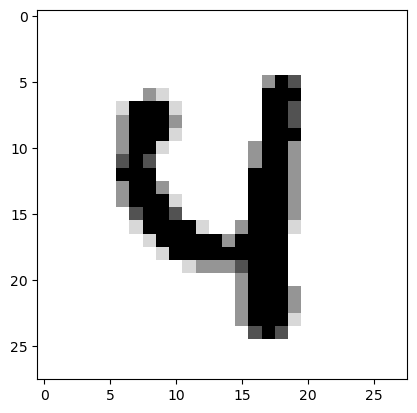

In [171]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [172]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        # run the backward 
        self.d( self.backptr, self.gradient )
        for o in self.backptr:
            if isinstance(o, Tensor) and not isinstance(o, Parameter) and o.require_grad:
                o.backward()
    
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [173]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [174]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [175]:
def tanh(x):
    # apply the tanh function to the input data
    v = np.tanh(x.data)
    # create a new tensor with the output and whether or not to require gradients
    output = Tensor(v, require_grad=x.require_grad)
    # define the backward function to be used later during backpropagation
    output.d = backward_tanh
    # store the input tensor to be used later during backpropagation
    output.backptr = [x]

    return output

def backward_tanh(backptr, g):
    # unpack the input tensor from the backpointer
    x, = backptr
    if x.require_grad:
        # calculate the derivative of the tanh function
        dtanh = 1 - np.tanh(x.data)**2
        # accumulate the gradient to the input tensor
        x.accumulate_gradient(g * dtanh)


Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [176]:
def affine_transform(W, b, x):
    """
    Input:
    - W: a Parameter of shape (D, M)
    - b: a Parameter of shape (M,)
    - x: a Tensor of shape (D,)
    Output:
    - a Tensor of shape (M,)
    """
    v = W.data @ x.data + b.data
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    
    return output


def backward_affine_transform(backptr, g):

    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(g.reshape(-1, 1) @ x.data.reshape(1, -1))
    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        # (10, 100) (10,) (100,) (10,)
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(W.data.T @ g)



In [177]:


# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    # Shift input for numerical stability
    x = x - np.max(x)
    # Compute exponential of each element
    x = np.exp(x)
    # Divide by the sum of exponential
    x = x / np.sum(x)
    return x

def nll(x, gold):
    # Compute negative log likelihood of x given gold
    v = -np.log(_softmax(x.data)[gold])
    # Create a new Tensor to store the output and keep track of the gradient
    output = Tensor(v, require_grad=x.require_grad)
    # Set the backward function to be called when computing gradients
    output.d = backward_nll
    # Save pointers to the inputs (x and gold) for backward computation
    output.backptr = [x, gold]
    
    return output

def backward_nll(backptr, g):
    x, gold = backptr
    
    # Accumulate gradient only if required
    if x.require_grad:
        # Compute the softmax of x
        ft=_softmax(x.data)
        # Subtract 1 from the correct class probability
        ft[gold] -= 1
        # Accumulate the gradient (element-wise multiplication)
        x.accumulate_gradient(g * ft)


# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [178]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [179]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    # Calculate the limit for the uniform distribution
    limit = np.sqrt(6.0 / (W.shape[0] + W.shape[1]))
    # Sample from a uniform distribution
    W[:] = np.random.uniform(-limit, limit, W.shape)
    
# Look at slides for the formula!
def kaiming_init(W):
    # Calculate the limit for the uniform distribution
    limit = np.sqrt(6.0 / W.shape[1])
    # Sample from a uniform distribution
    W[:] = np.random.uniform(-limit, limit, W.shape)

In [180]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1,use_weight_decay=False,weight_decay=0.001):
        self.params = params
        self.lr = lr
        self.use_weight_decay=use_weight_decay
        self.weight_decay=weight_decay
    def step(self):
        for p in self.params:
            if self.use_weight_decay:
                if p.name=='W':
                    p.data[:] = p.data - self.lr * (p.gradient+self.weight_decay*p.data)
            else:
                p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [181]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [182]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [183]:
# function to get accuracy on the test data
def get_accuracy(network, data):
    # Compute the number of test samples
    n_data = data[0].shape[0]
    # Initialize the number of correctly classified test samples
    correct = 0
    for x, y in zip(data[0], data[1]):
        # Compute the output of the model on the input x
        y_hat = network.forward(Tensor(x))
        # Check if the predicted label matches the true label y
        correct += int(np.argmax(_softmax(y_hat.data)) == y)
    # Compute the accuracy on the test set
    accuracy = correct / n_data
    return accuracy

In [184]:

def training_loop(network, optimizer, train_data, dev_data, n_epochs=10, verbose=True):

    # Number of training samples
    n_training = train_data[0].shape[0]
    n_dev = dev_data[0].shape[0]

    # Array containing some stats
    avg_losses = np.zeros(n_epochs)
    train_acc = np.zeros(n_epochs)
    dev_acc_epoch = np.zeros(n_epochs)
    dev_acc  =[]
    total_acc_values=[]
     
    # parameters to store score and parameters of the best model on dev
    best_dev_accuracy = 0
    best_params = None  
    

    # For each epoch...
    for epoch_i in range(n_epochs ):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
        
        if verbose:
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs ))

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        train_loss = 0
        train_correct = 0

        # shuffle the data before each epoch
        indices = np.random.permutation(n_training)
        train_data_shuffled = (train_data[0][indices], train_data[1][indices])   

        for i, (x, y) in enumerate (zip (train_data_shuffled[0], train_data_shuffled[1])):
            if (i+1)% 10000 == 0:
                if verbose:
                    print("Training...")
            # forward pass
            y_hat = network.forward(Tensor(x))
            loss= nll(y_hat, y)
            
            train_loss += loss.data

            # backward pass
            optimizer.zero_grad()
            loss.backward(1.0)
            optimizer.step()

            # compute accuracy on train set
            train_correct += int(np.argmax(y_hat.data) == y)

            # evaluate the model on the dev data after 10000 training examples (5 evaluation per epoch on dev)
            if (i+1)% 10000 == 0:
                if verbose:
                    print("Evaluating on dev set...")
                local_acc=[]
                dev_correct = 0
                for x, y in zip(dev_data[0], dev_data[1]):
                    y_hat = network.forward(Tensor(x))
                    dev_correct += int(np.argmax(_softmax(y_hat.data)) == y)

                dev_accuracy = dev_correct / n_dev  
                if verbose:
                    print(f" current Dev accuracy: {dev_accuracy:.3f}")
                local_acc.append(dev_accuracy)
                dev_acc.append(dev_accuracy)

                # check if dev accuracy has improved and update best parameters
                if dev_accuracy > best_dev_accuracy:
                    best_dev_accuracy = dev_accuracy
                    best_params = (network.W, network.b)

        
        # Compute avg loss, avg train accuracy and dev accuracy
        avg_losses[epoch_i] = train_loss/ n_training
        train_acc[epoch_i]  = train_correct/ n_training
        total_acc_values.append(dev_acc)

        dev_acc_epoch[epoch_i] = max(dev_acc)
            # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        
        if verbose: 
            print("---------------------------------")
            print(f"Avg_loss: {avg_losses[epoch_i]:.3f}")
            print(f"Train accuracy: {train_acc[epoch_i]}")
            print(f"Best dev accuracy: {best_dev_accuracy:.3f}")
            print("Dev accuracy epoch: {:}".format(dev_acc_epoch[epoch_i]))
            print("Training epcoh took: {:}".format(training_time))
            print(" ---------------------------------")
        dev_acc = []
   
    return {"losses": avg_losses, "train_acc": train_acc, "dev_acc": dev_acc_epoch}, best_params


In [185]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
Evaluating on dev set...
 current Dev accuracy: 0.902
Training...
Evaluating on dev set...
 current Dev accuracy: 0.912
Training...
Evaluating on dev set...
 current Dev accuracy: 0.908
Training...
Evaluating on dev set...
 current Dev accuracy: 0.917
Training...
Evaluating on dev set...
 current Dev accuracy: 0.921
---------------------------------
Avg_loss: 0.378
Train accuracy: 0.89272
Best dev accuracy: 0.921
Dev accuracy epoch: 0.9213
Training epcoh took: 0:00:05
 ---------------------------------

======== Epoch 2 / 5 ========
Training...
Evaluating on dev set...
 current Dev accuracy: 0.922
Training...
Evaluating on dev set...
 current Dev accuracy: 0.920
Training...
Evaluating on dev set...
 current Dev accuracy: 0.922
Training...
Evaluating on dev set...
 current Dev accuracy: 0.921
Training...
Evaluating on dev set...
 current Dev accuracy: 0.921
---------------------------------
Avg_loss: 0.310
Train accuracy: 0.91224
Best dev accur

In [186]:
def plot_loss_acc(avg_losses, train_acc, dev_acc_epoch):
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the average losses on the first subplot
    ax[0].plot(avg_losses, label='train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot the train and dev accuracies on the second subplot
    ax[1].plot(train_acc, label='train accuracy')
    ax[1].plot(dev_acc_epoch, label='dev accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

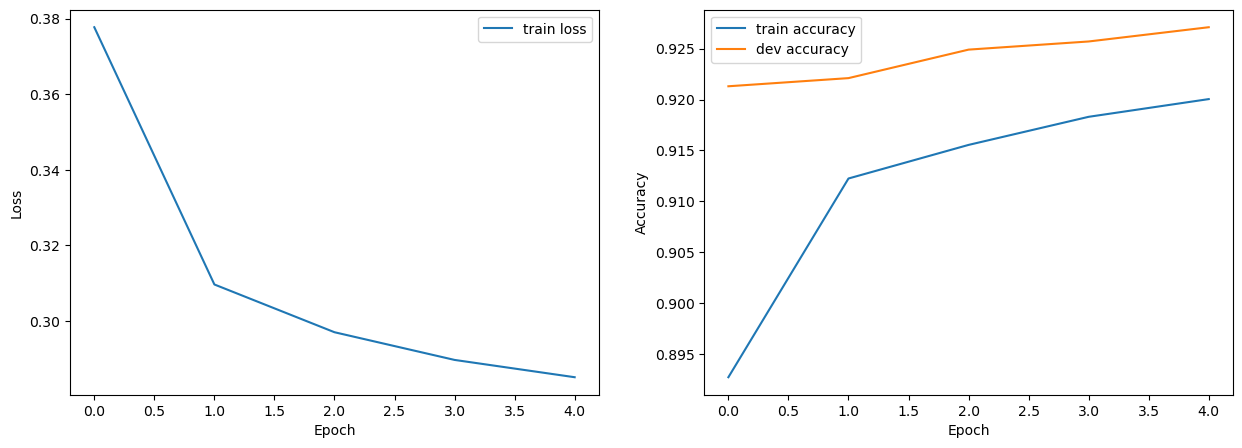

In [187]:
plot_loss_acc(history["losses"], history["train_acc"], history["dev_acc"])

In [188]:
n_test = test_data[0].shape[0]
network.W, network.b = best_params
print("Test accuracy = %.4f" % get_accuracy(network,test_data))

Test accuracy = 0.9196


After you finished the linear network, you can move to a deep network!

In [189]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, use_tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        self.activation = relu if not use_tanh else tanh
        self.n_layers = n_layers
        self.init = glorot_init if use_tanh else kaiming_init

        # Add the input layer
        self.W.append(Parameter(np.ndarray((hidden_dim, dim_input)), name="W"))
        self.b.append(Parameter(np.ndarray((hidden_dim,)), name="b"))

        # Add the hidden layers
        for _ in range(1, n_layers):
            self.W.append(Parameter(np.ndarray((hidden_dim, hidden_dim)), name="W"))
            self.b.append(Parameter(np.ndarray((hidden_dim,)), name=f"b"))

        # Add the output layer
        self.output_proj = Parameter(np.ndarray((dim_output, hidden_dim)), name="W")
        self.output_bias = Parameter(np.ndarray((dim_output,)), name="b")

        self.init_parameters()

    def init_parameters(self):
        # Initialize the weights of the input and hidden layers
        for w, b in zip(self.W, self.b):
            self.init(w.data)
            zero_init(b.data)

        # Initialize the weights of the output layer
        self.init(self.output_proj.data)
        zero_init(self.output_bias.data)

    def forward(self, x):
        # Propagate the input through the hidden layers
        for w, b in zip(self.W, self.b):
            x = affine_transform(w, b, x)
            x = self.activation(x)

        # Propagate the output of the last hidden layer through the output layer
        return affine_transform(self.output_proj, self.output_bias, x)

In [190]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
Evaluating on dev set...
 current Dev accuracy: 0.917
Training...
Evaluating on dev set...
 current Dev accuracy: 0.943
Training...
Evaluating on dev set...
 current Dev accuracy: 0.955
Training...
Evaluating on dev set...
 current Dev accuracy: 0.947
Training...
Evaluating on dev set...
 current Dev accuracy: 0.956
---------------------------------
Avg_loss: 0.244
Train accuracy: 0.9257
Best dev accuracy: 0.956
Dev accuracy epoch: 0.9559
Training epcoh took: 0:00:30
 ---------------------------------

======== Epoch 2 / 5 ========
Training...
Evaluating on dev set...
 current Dev accuracy: 0.958
Training...
Evaluating on dev set...
 current Dev accuracy: 0.957
Training...
Evaluating on dev set...
 current Dev accuracy: 0.966
Training...
Evaluating on dev set...
 current Dev accuracy: 0.969
Training...
Evaluating on dev set...
 current Dev accuracy: 0.970
---------------------------------
Avg_loss: 0.119
Train accuracy: 0.96364
Best dev accura

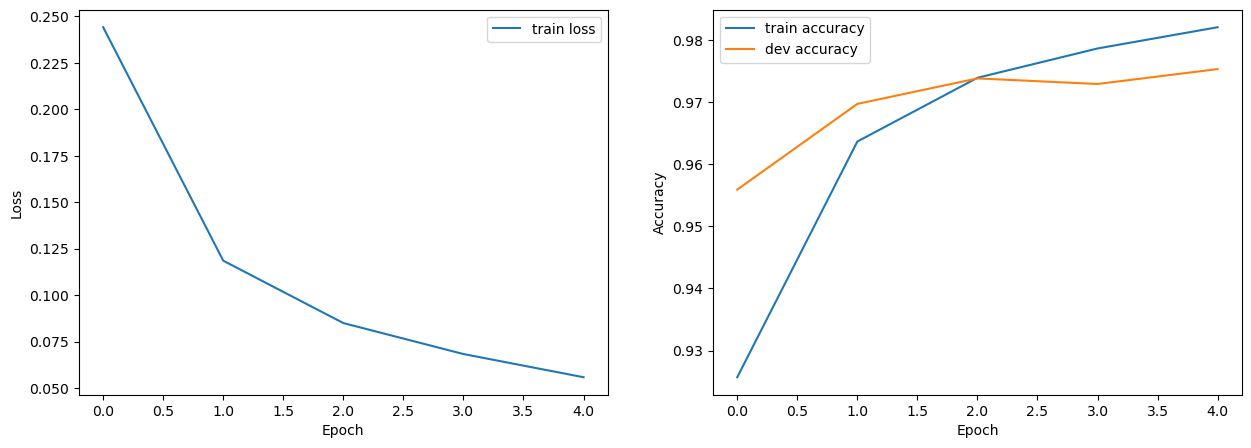

In [191]:
plot_loss_acc(history["losses"], history["train_acc"], history["dev_acc"])

In [192]:
network.W, network.b= best_params[0], best_params[1]
# Print the test accuracy
print("Test accuracy = %.4f" % get_accuracy(network, test_data))

Test accuracy = 0.9700


### Experimentations

    1. Use weight decay and tanh as activation function.

In [193]:
dim_input = 28*28
dim_output = 10

network1= DeepNetwork(dim_input, dim_output, 100, 2, use_tanh=True)
optimizer = SGD(network1.parameters(), 0.01,use_weight_decay=True)

history1, best_params1=training_loop(network1, optimizer, train_data, dev_data, n_epochs=5, verbose=False)

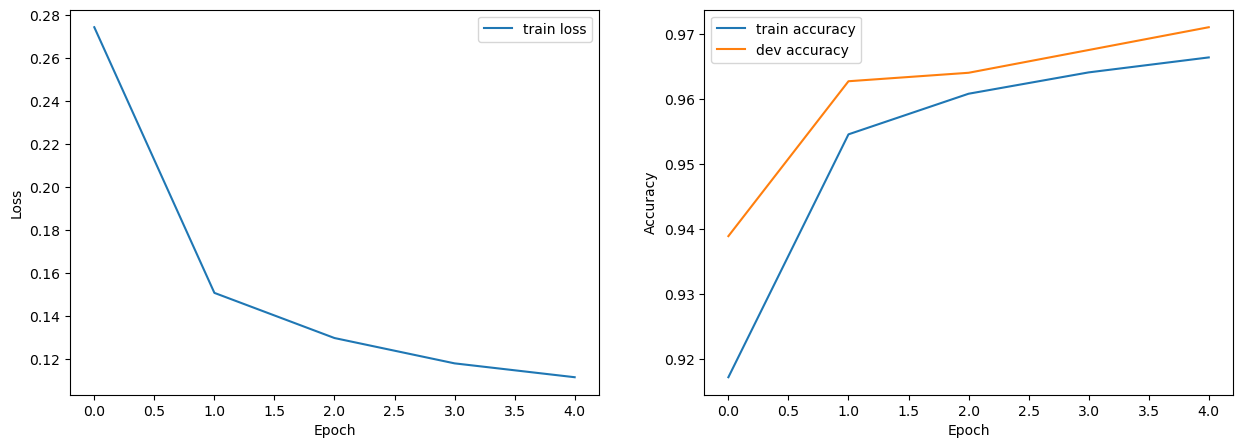

In [194]:
plot_loss_acc(history1["losses"], history1["train_acc"], history1["dev_acc"])

    2. Use weight decay and Relu as activation function.

In [195]:
dim_input = 28*28
dim_output = 10

network2= DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network2.parameters(), 0.01,use_weight_decay=True)

history2, best_params2=training_loop(network2, optimizer, train_data, dev_data, n_epochs=5, verbose=False)

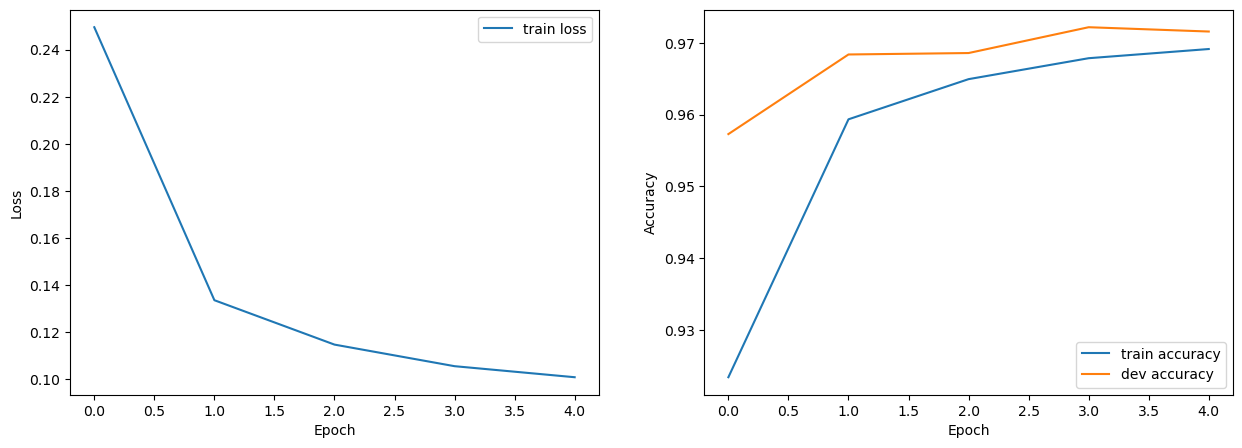

In [196]:
plot_loss_acc(history2["losses"], history2["train_acc"], history2["dev_acc"])

    3. Use Relu as activation function with 2 hidden layers.

In [197]:
dim_input = 28*28
dim_output = 10

network3= DeepNetwork(dim_input, dim_output, 100, 3)
optimizer = SGD(network3.parameters(), 0.01)

history3, best_params3=training_loop(network3, optimizer, train_data, dev_data, n_epochs=5, verbose=False)

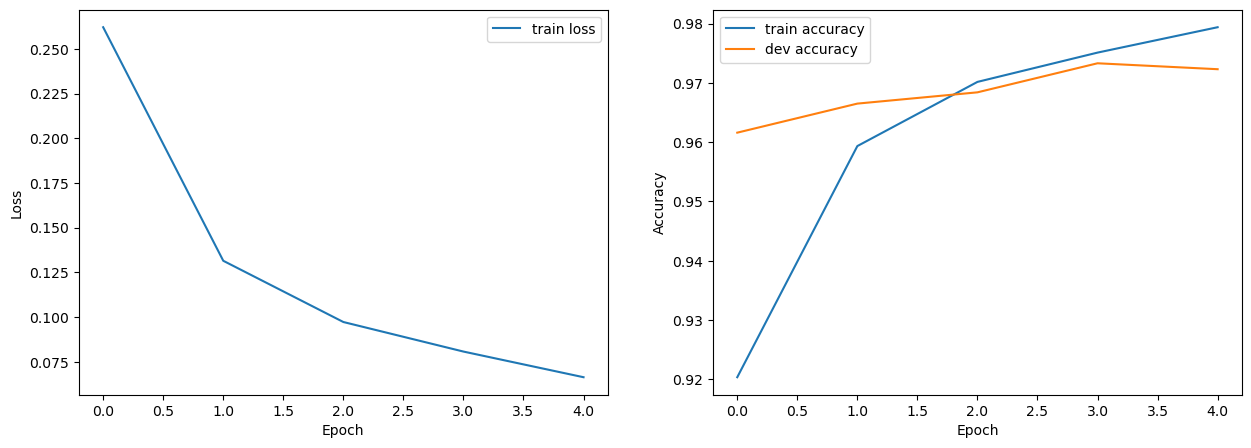

In [198]:
plot_loss_acc(history3["losses"], history3["train_acc"], history3["dev_acc"])

## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


In [199]:
class MomentumSGD:
    def __init__(self, params, lr=0.1, momentum=0.9):
        # Initialize the optimizer with the given hyperparameters
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.momentum_buffers = {}
        
    def step(self):
        # Take one step of the optimizer and compute the new velocity using the momentum formula
        for p in self.params:
            #if gradient is None, we won't compute the velocity
            if p.gradient is None:
                continue
                
            d_p = p.gradient
            if p not in self.momentum_buffers:
                # Initialize the momentum buffer to zero
                self.momentum_buffers[p] = np.zeros_like(d_p)
            #update velocity
            buf = self.momentum_buffers[p]
            buf *= self.momentum
            buf += d_p* ( 1- self.momentum)
            #update parameters
            p.data -= self.lr * buf
            #store velocity values for each parameter
            self.momentum_buffers[p] = buf
        
    def zero_grad(self):
        # Reset the gradients for each parameter to zero
        for p in self.params:
            p.gradient = None


In [200]:
dim_input = 28*28
dim_output = 10

network4 = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = MomentumSGD(network4.parameters(), 0.01)

history4, best_params4 = training_loop(network4, optimizer, train_data, dev_data, n_epochs=5, verbose=False)

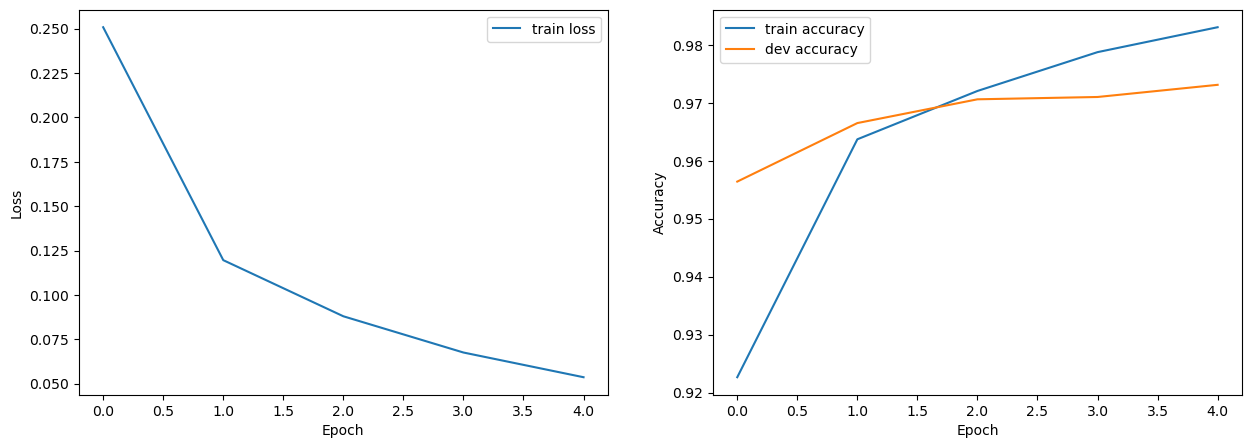

In [201]:
plot_loss_acc(history4["losses"], history4["train_acc"], history4["dev_acc"])

### Results

In [202]:
# Convert each dictionary to a pandas DataFrame
import pandas as pd
hist = pd.DataFrame(history).max()
hist1 = pd.DataFrame(history1).max()
hist2 = pd.DataFrame(history2).max()
hist3 = pd.DataFrame(history3).max()
hist4 = pd.DataFrame(history4).max()
result_df = pd.concat([hist, hist1, hist2, hist3, hist4], axis=1, keys=['Relu', 'Weight decay + tanh', 'Weight decay + Relu', 'Relu + 2 hidden Layer', 'MomentumSGD + Relu']).T
print(result_df.drop(['losses'], axis=1))

                       train_acc  dev_acc
Relu                     0.98204   0.9753
Weight decay + tanh      0.96636   0.9710
Weight decay + Relu      0.96916   0.9722
Relu + 2 hidden Layer    0.97938   0.9733
MomentumSGD + Relu       0.98304   0.9731


### Hyper parameter tuning :

#### Momentum value:

In [133]:
#Define values to test for the momentum
momentum = [0, 0.01, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]
#create the grid
grid= []
for vmom in momentum:
                    grid.append({
                    'momentum': vmom,
                })

In [205]:
# Initialize variables to store the best parameters and highest accuracy
best_params = None
best_accuracy = 0

results = []
n_iter = len(grid)

dim_input = 28*28
dim_output = 10

# Perform the grid search
for params in grid :
    
    #get the accuracy for each momentum value
    network = DeepNetwork(dim_input, dim_output, 100, 2)
    optimizer = MomentumSGD(network.parameters(), 0.01, params['momentum'])
    history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=5, verbose=False)
    accuracy = history['dev_acc'].max()
    
    # save the values
    tmp_result = dict(params)
    tmp_result['accuracy'] = accuracy
    results.append(tmp_result)
    
    #update best_accuracy and best_parameter value
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params['momentum']

print('Best Accuracy', best_accuracy)
print('Best momentum Value', best_params)


Best Accuracy 0.9777
Best momentum Value 0.9


,momentum,accuracy
0,0.00,0.9759
1,0.01,0.9752
2,0.10,0.9743
3,0.30,0.9760
4,0.50,0.9742
5,0.70,0.9771
6,0.80,0.9755
7,0.90,0.9777
0,1.00,0.1310


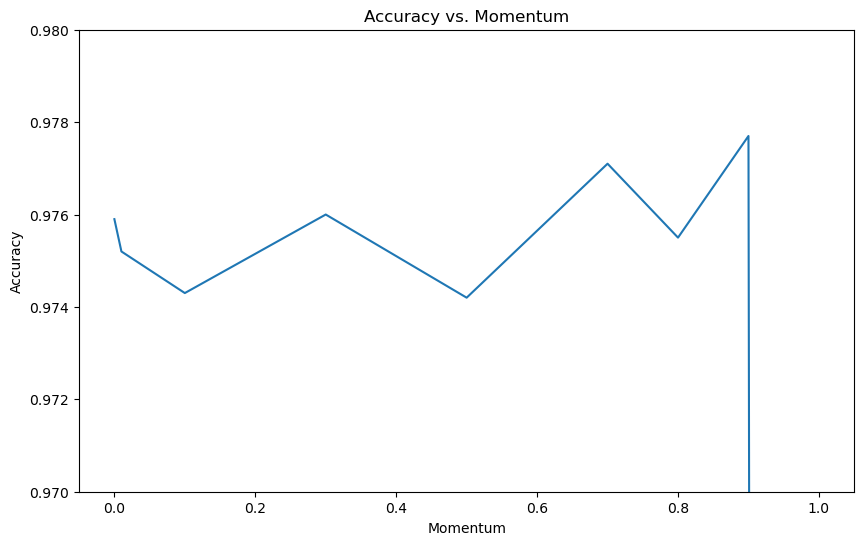

In [167]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df['momentum'], results_df['accuracy'])

ax.set_xlabel('Momentum')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Momentum')
plt.ylim(0.97, 0.98)
plt.show()

### Learning rate

In [213]:
#Defining parameters to hypertune and their range
lr = [0.001, 0.01, 0.05]

In [214]:
#build the grid from parameters 
grid = []
for vlr in lr:
        grid.append({
        'lr': vlr,
                  })

In [221]:
# Initialize variables to store the best parameters and highest accuracy
best_params = None
best_accuracy = 0

results = []
n_iter = len(grid)

dim_input = 28*28
dim_output = 10
# Perform the grid search
for params in grid :
    
    #get the accuracy with parameters
    network = DeepNetwork(dim_input, dim_output,100,2)
    optimizer = SGD(network.parameters(), params['lr'])
    history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=5, verbose=False)
    
    accuracy = history['dev_acc'].max()
    tmp_result = dict(params)
    tmp_result['accuracy'] = accuracy

    results.append(tmp_result)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params['lr']

print("\nBest LR value:", best_params)
print("Highest Accuracy:", best_accuracy)

results_df = pd.DataFrame(results)
results_df


Best LR value: 0.01
Highest Accuracy: 0.9748


,lr,accuracy
0,0.001,0.9690
1,0.010,0.9748
2,0.050,0.9212


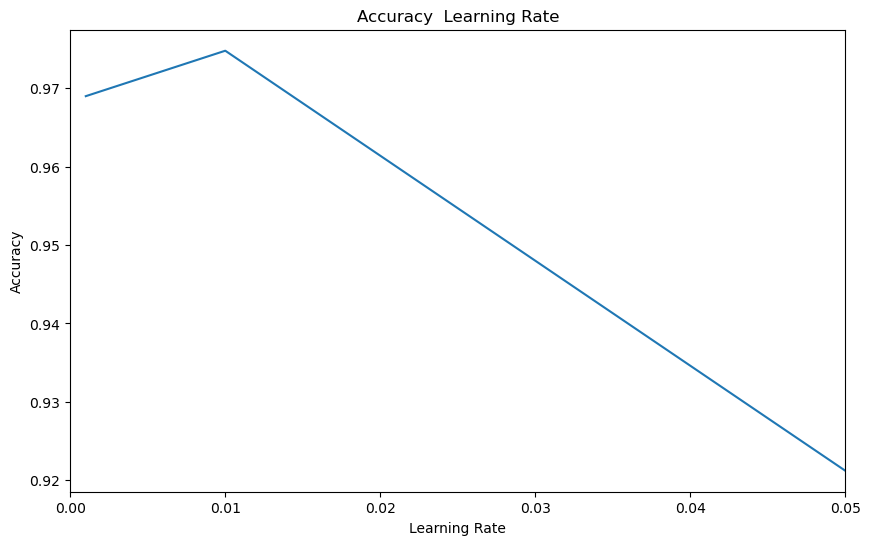

In [217]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df['lr'], results_df['accuracy'])

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Vs Learning Rate')
plt.xlim(0, 0.05)
plt.show()

In [223]:
n_layers = [2, 4, 6]
hidden_dim = [64, 128, 256]

In [224]:
#build the grid from parameters 
grid = []
for vnbl in n_layers:
    for vhd in hidden_dim:
        grid.append({
        'n_layers': vnbl,
        'hidden_dim': vhd
                  })

In [237]:
# Initialize variables to store the best parameters and highest accuracy
best_params = None
best_accuracy = 0

results = []
n_iter = len(grid)
dim_input = 28*28
dim_output = 10

# Perform the grid search
for params in grid :
    #get the accuracy with parameters
    network = DeepNetwork(dim_input, dim_output,params['hidden_dim'],params['n_layers'])
    optimizer = SGD(network.parameters(), 0.01)
    history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=5, verbose=False)
    
    accuracy = history['dev_acc'].max()
    tmp_result = dict(params)
    tmp_result['accuracy'] = accuracy

    results.append(tmp_result)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (params['n_layers'],params['hidden_dim'])
        
print("\nBest parameters: n_layers", best_params[0], "hidden_dim", best_params[1])
print("Highest Dev Accuracy:", best_accuracy)

results_df = pd.DataFrame(results)
results_df


Best parameters: n_layers 4 hidden_dim 256
Highest Accuracy: 0.9795


,n_layers,hidden_dim,accuracy
0,2,64,0.9727
1,2,128,0.9743
2,2,256,0.9795
3,4,64,0.9709
4,4,128,0.9723
5,4,256,0.9786
6,6,64,0.9664
7,6,128,0.9707
8,6,256,0.9775


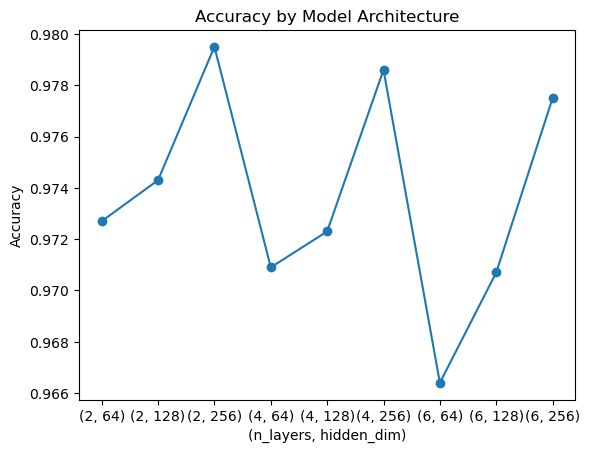

In [239]:
plt.plot(range(len(results_df['accuracy'])), results_df['accuracy'], 'o-')
plt.xticks(range(len(results_df['accuracy'])), [f"({results_df['n_layers'][i]}, {results_df['hidden_dim'][i]})" for i in range(len(results_df['accuracy']))])
plt.xlabel("(n_layers, hidden_dim)")
plt.ylabel("Accuracy")
plt.title("Accuracy by Model Architecture")
plt.show()

### Weight decay

In [241]:
weight_decay = [0.0001,0.001, 0.005, 0.1, 0.2]
#build the grid from parameters 
grid = []
for vwd in weight_decay:
        grid.append({
        'weight_decay': vwd,
                  })

In [262]:
# Initialize variables to store the best parameters and highest accuracy
best_params = None
best_accuracy = 0

results_2 = []
n_iter = len(grid)

dim_input = 28*28
dim_output = 10
i=0
# Perform the grid search
for params in grid :
    #get the accuracy with parameters
    network = DeepNetwork(dim_input, dim_output,100,2)
    optimizer = SGD(network.parameters(), 0.01, True, weight_decay = params['weight_decay'])
    history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=5, verbose=False)
    
    accuracy = history['dev_acc'].max()
    tmp_result = dict(params)
    tmp_result['accuracy'] = accuracy

    results_2.append(tmp_result)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params['weight_decay']
        
print("\nBest value for weight_decay", best_params)
print("Highest Dev Accuracy:", best_accuracy)

results_df_2 = pd.DataFrame(results_2)
results_df_2


Best value for weight_decay 0.001
Highest Dev Accuracy: 0.9725


,weight_decay,accuracy
0,0.001,0.9725
1,0.005,0.9585
2,0.100,0.7761
3,0.200,0.4233


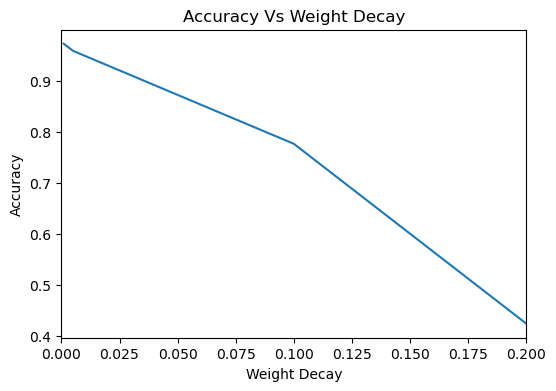

In [264]:

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(results_df_2['weight_decay'], results_df_2['accuracy'])

ax.set_xlabel('Weight Decay')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Vs Weight Decay')
plt.xlim(0, 0.2)
plt.show()